In [1]:

from importlib import reload


import pandas as pd
import numpy as np

from sklearn import preprocessing
from statsmodels.stats.multicomp import pairwise_tukeyhsd


import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns

from plotly.offline import download_plotlyjs, init_notebook_mode, plot,iplot
init_notebook_mode(connected=True)
import plotly.graph_objs as go

import analysis2 as a2
from flutype.utils import django_setup
from flutype.models import Spot



from IPython.display import display_html
def display_side_by_side(*args):
    html_str=''
    for df in args:
        html_str+=df.to_html()
    display_html(html_str.replace('table', 'table style="display:inline"'), raw=True)


****************************************
RUNNING IN DEVELOP
****************************************


## Load Elisa Data

In [2]:
reload(a2)
studies = ["elisa_2018_03_28"]
analyte_batches = ["A/Aichi/2/68(H3N2)-4-5",
                  "A/Aichi/2/68(H3N2)-4-10",
                  "A/Aichi/2/68(H3N2)-4-20",
                  'A/Brisbane/10/2007(H3N2)-10',
                  'A/Brisbane/10/2007(H3N2)-20',
                  'A/Brisbane/10/2007(H3N2)-5',
                  'A/Brisbane/59/2007(H1N1)-10',
                  'A/Brisbane/59/2007(H1N1)-20',
                  'A/Brisbane/59/2007(H1N1)-5',
                  'A/California/07/2009(H1N1)-3-10',
                  'A/California/07/2009(H1N1)-3-20',
                  'A/California/07/2009(H1N1)-3-5',
                  'A/Hong Kong/4801/2014(H3N2)-10',
                  'A/Hong Kong/4801/2014(H3N2)-20',
                  'A/Hong Kong/4801/2014(H3N2)-5',
                  'A/Panama/2007/1999(H3N2)-3-10',
                 'A/Panama/2007/1999(H3N2)-3-20',
                 'A/Panama/2007/1999(H3N2)-3-5',
                   "Buffer001",
                  ]
spots_dj = Spot.objects.filter(raw_spot__raw_spot_collection__studies__sid__in=studies)
spots_dj = spots_dj.filter(raw_spot__lig_mob_batch__sid__in=analyte_batches)
data_elisa = a2.Data(spots_dj=spots_dj, impute=True)#.outlier_filtering()

In [3]:
# results dictionary
frames = {}
# iterate over collections and analyte batch
for cn, d in data_elisa.spots_pd.groupby(["Collection", "Analyte Batch"]):
    # normalize with respective buffer value
    x = d.copy()
    buffer_ref = d[d["Ligand Batch"] == "Buffer001"].Intensity.mean()
    x.Intensity = d.Intensity/buffer_ref
    frames[cn] = x
spots_pd_norm = pd.concat(frames)
data_elisa_norm1 = a2.Data(spots_pd=spots_pd_norm,impute=True)

In [4]:
frames = {}
for cn, d in data_elisa.spots_pd.groupby(["Collection", "Ligand Batch"]):
    x = d.copy()
    buffer_ref = d[d["Analyte Batch"] == "Buffer001"]["Intensity"].mean()
    x["Intensity"] = d["Intensity"]/buffer_ref
    frames[cn] = x
spots_pd_norm = pd.concat(frames)
data_elisa_norm2 = a2.Data(spots_pd=spots_pd_norm,impute=True)

In [5]:
frames = {}
for cn, d in  data_elisa_norm1.spots_pd.groupby(["Collection","Ligand Batch"]):
    x = d.copy()
    x["Intensity"] = d["Intensity"]/d[d["Analyte Batch"] == "Buffer001"]["Intensity"].mean()
    frames[cn]=x
spots_pd_norm = pd.concat(frames)
data_elisa_norm3 = a2.Data(spots_pd=spots_pd_norm,impute=True)

In [6]:
frames = {}
for cn, d in  data_elisa.spots_pd.groupby(["Collection","Analyte Batch"]):
    x = d.copy()
    x["Intensity"] = d["Intensity"]-d[d["Ligand Batch"] == "Empty"]["Intensity"].mean()
    x["Intensity"] = x["Intensity"]/x[x["Ligand Batch"] == "Buffer001"]["Intensity"].mean()
    frames[cn]=x
spots_pd_norm = pd.concat(frames)

frames = {}
for cn, d in  spots_pd_norm.groupby(["Collection","Ligand Batch"]):
    x = d.copy()
    x["Intensity"] = d["Intensity"]/d[d["Analyte Batch"] == "Buffer001"]["Intensity"].mean()
    frames[cn]=x
spots_pd_norm = pd.concat(frames)

spots_pd_norm.at[spots_pd_norm["Ligand Batch"] == "Empty","Intensity"] = 0  # remove NaNs/Infs 
data_elisa_norm4 = a2.Data(spots_pd=spots_pd_norm,impute=True)

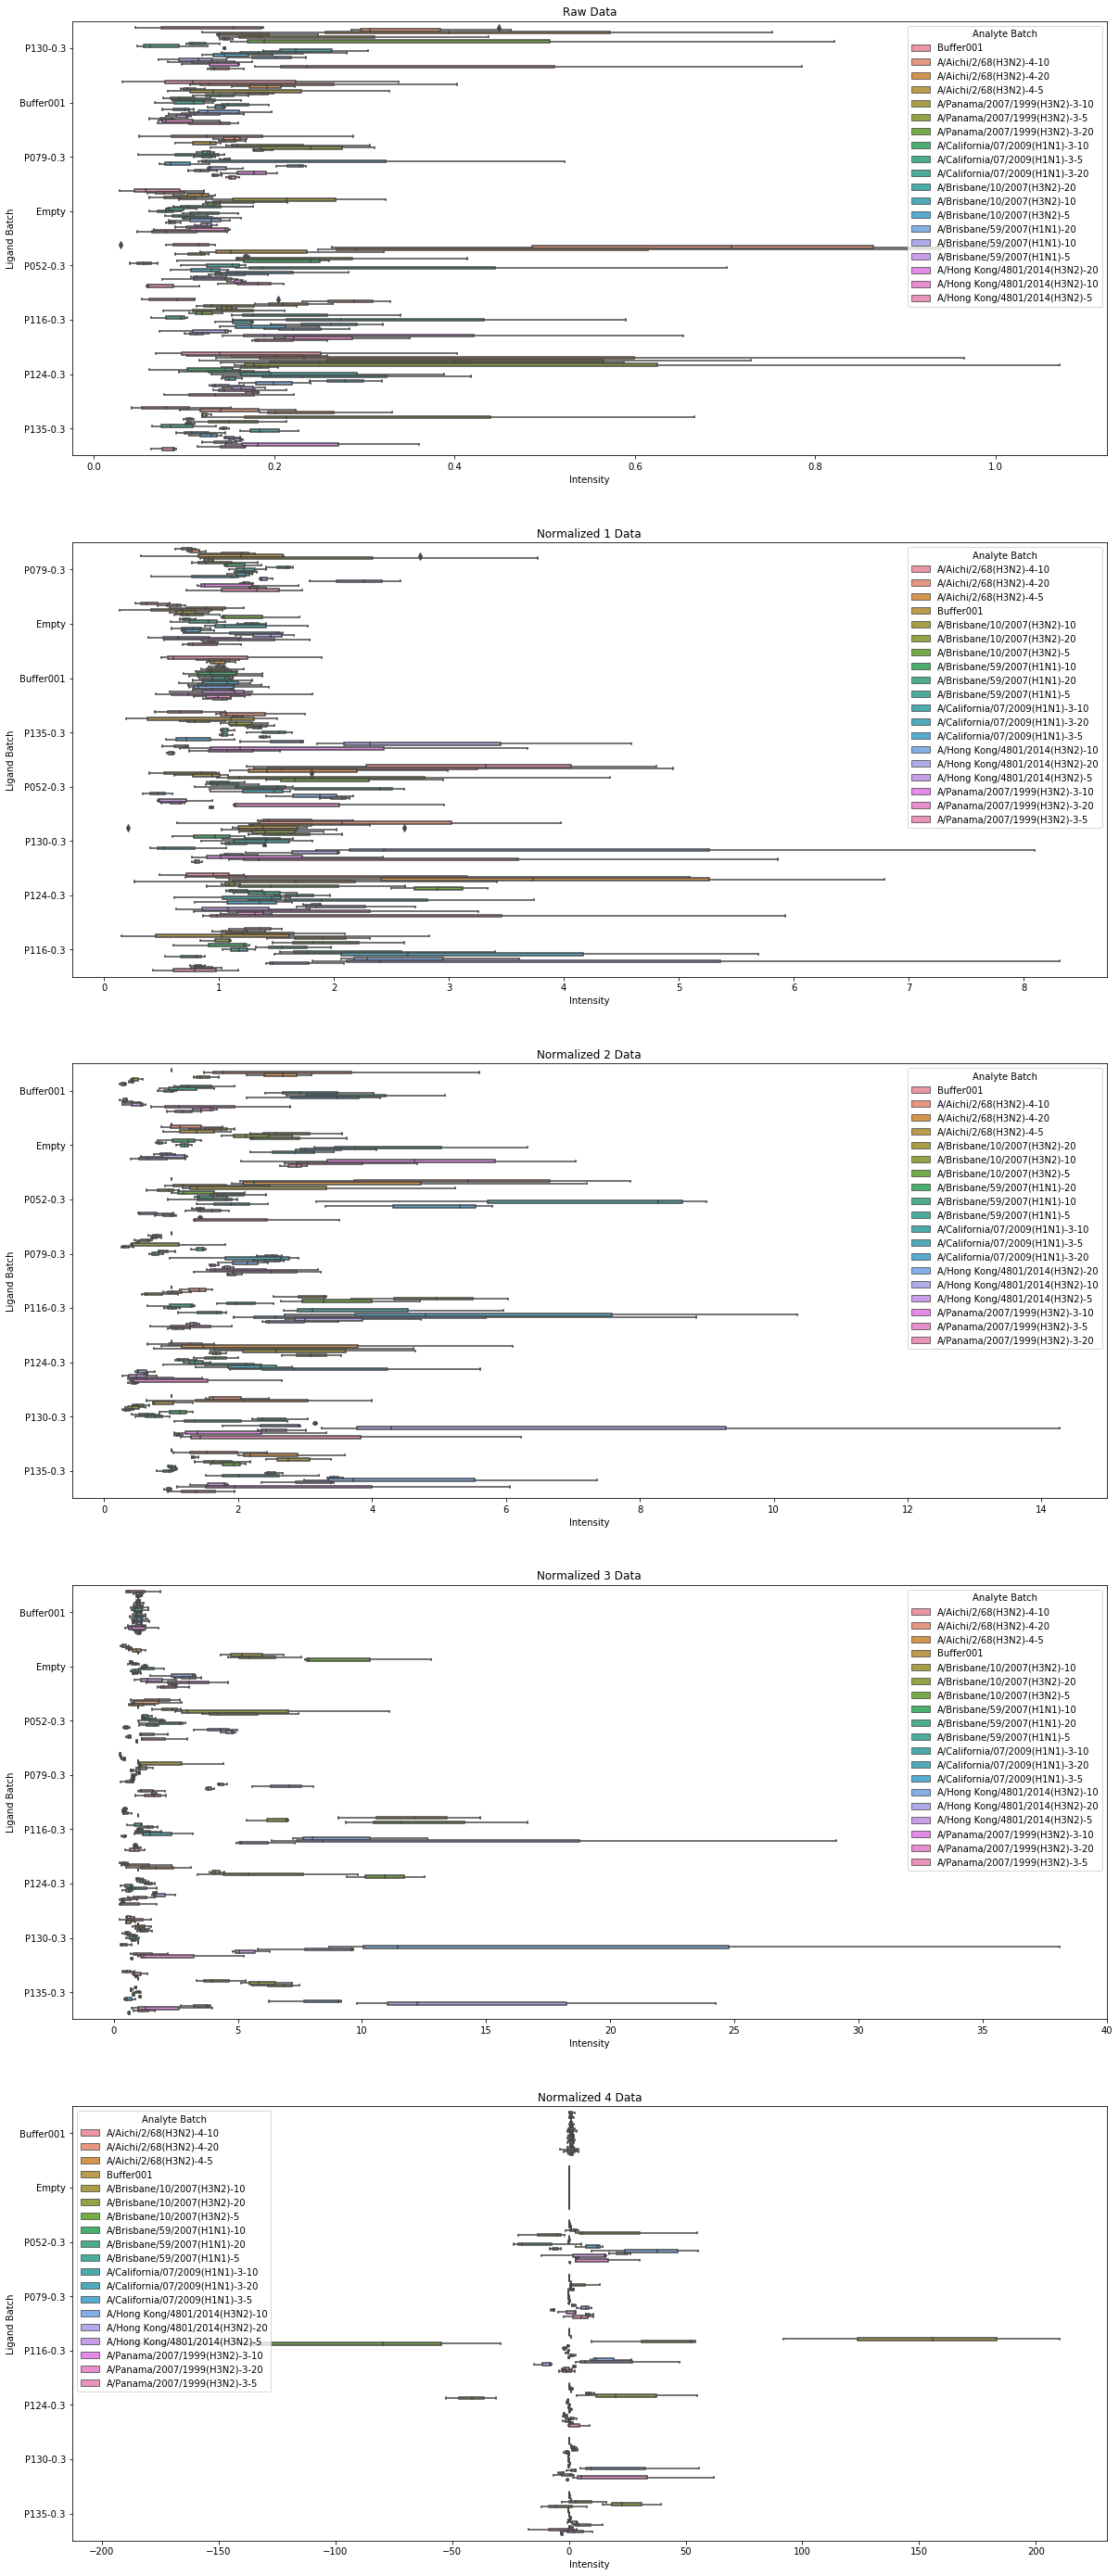

In [7]:
fig ,ax = plt.subplots(ncols=1,nrows=5,figsize=(20,50))
ax[0].set_title("Raw Data")
#ax[0,1].set_title("Raw Data")
ax[1].set_title("Normalized 1 Data")
#ax[1,1].set_title("Normalized 1 Data")
ax[2].set_title("Normalized 2 Data")
#ax[2,1].set_title("Normalized 2 Data")
ax[3].set_title("Normalized 3 Data")
#ax[3,1].set_title("Normalized 3 Data")
ax[4].set_title("Normalized 4 Data")
#ax[4,1].set_title("Normalized 4 Data")
#sns.boxplot(data=data_elisa.spots_pd, x="Intensity", hue="Collection", y="Ligand Batch", ax=ax[0,0])
sns.boxplot(data=data_elisa.spots_pd, x="Intensity", y="Ligand Batch", hue="Analyte Batch", ax=ax[0],)
#sns.boxplot(data=data_elisa_norm1.spots_pd, x="Intensity", y="Ligand Batch", hue="Collection", ax=ax[1,0])
sns.boxplot(data=data_elisa_norm1.spots_pd, x="Intensity", y="Ligand Batch", hue="Analyte Batch", ax=ax[1],)
#sns.boxplot(data=data_elisa_norm2.spots_pd, x="Intensity", y="Ligand Batch", hue="Collection", ax=ax[2,0])
sns.boxplot(data=data_elisa_norm2.spots_pd, x="Intensity", y="Ligand Batch", hue="Analyte Batch", ax=ax[2],)
#sns.boxplot(data=data_elisa_norm3.spots_pd, x="Intensity", y="Ligand Batch", hue="Collection", ax=ax[3,0])
sns.boxplot(data=data_elisa_norm3.spots_pd, x="Intensity", y="Ligand Batch", hue="Analyte Batch", ax=ax[3],)
#sns.boxplot(data=data_elisa_norm4.spots_pd, x="Intensity", y="Ligand Batch", hue="Collection", ax=ax[4,0])
sns.boxplot(data=data_elisa_norm4.spots_pd, x="Intensity", y="Ligand Batch", hue="Analyte Batch", ax=ax[4],)
plt.show()

## Load Reference  Data

In [8]:
studies = ["microarray_2018_03_21"]
spots_dj_reference = Spot.objects.filter(raw_spot__raw_spot_collection__studies__sid__in=studies)
spots_dj_reference = spots_dj_reference.filter(spot_collection__sid = "quant1")
data_reference = a2.Data(spots_dj=spots_dj_reference).outlier_filtering().sample_on_collection(20).clean()

ValueError: Empty data passed with indices specified.

## Rank Peptides by Relafance in Reference Data

In [ ]:
frames = []
for n, d in data_reference.spots_pd.groupby("Ligand Batch"):
    
    tukey = pairwise_tukeyhsd(endog=d["Intensity"], groups=d["Analyte Batch"],alpha=0.01)
    frames.append(pd.Series({"Ligand Batch":n,"Distinct Groups":np.count_nonzero(tukey.reject)}))
pepsig = pd.concat(frames, axis=1).transpose().sort_values(by="Distinct Groups", ascending=False)
peptides_ranking = pd.Series(pepsig["Distinct Groups"].values,index=pepsig["Ligand Batch"])  

In [ ]:
peptides_ranking.to_clipboard()

In [ ]:
ma_ana = data_elisa.mean_on_analyte_batch().groupby(["Analyte Batch"]).mean()["Intensity_rsd"]
ma_lig = data_elisa.mean_on_analyte_batch().groupby(["Ligand Batch"]).mean()["Intensity_rsd"]
ma_lig_norm1 = data_elisa_norm1.mean_on_analyte_batch().groupby(["Ligand Batch"]).mean()["Intensity_rsd"]
ma_lig_norm2 = data_elisa_norm2.mean_on_analyte_batch().groupby(["Ligand Batch"]).mean()["Intensity_rsd"]
ma_lig_norm3 = data_elisa_norm3.mean_on_analyte_batch().groupby(["Ligand Batch"]).mean()["Intensity_rsd"]
ma_lig_norm4 = data_elisa_norm4.mean_on_analyte_batch().groupby(["Ligand Batch"]).mean()["Intensity_rsd"]

In [ ]:
#peptides_ranking.to_clipboard()

Check  relevance of peptides in elisa study by relevance in reference data set 

In [ ]:
print("From {} petides the follwing petides ranked:".format(len(peptides_ranking)))

for ligand in  data_elisa.spots_pd["Ligand Batch"].unique():
    
    if "0.3" in str(ligand):
        peptide = str(ligand)[:-4]
        try:
            print("{}:{}".format(peptide,peptides_ranking.index.get_loc(peptide)))
        except KeyError:
            print("{} is not in reference data set".format(peptide))


Selected Peptide have rather low relevance. This is bad.

## Check concentration dependence in elisa data set

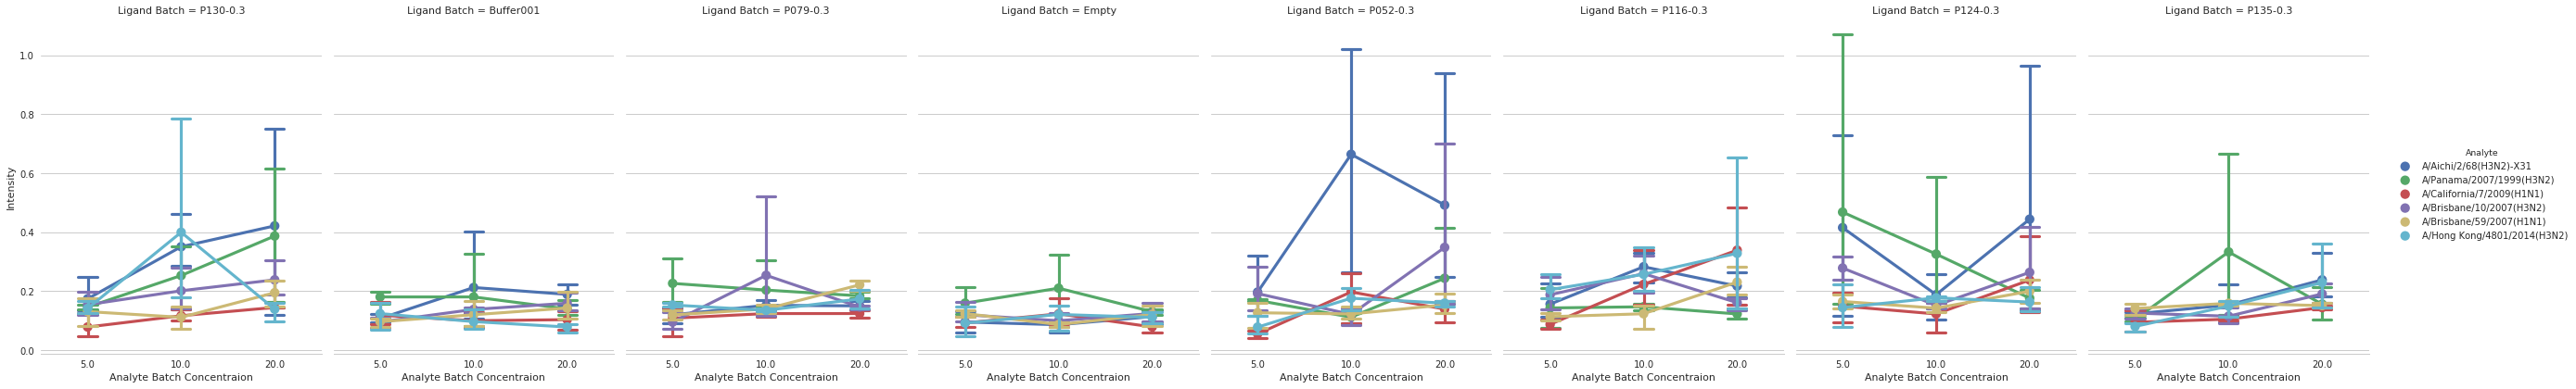

In [11]:
sns.set(style="whitegrid")
g = sns.factorplot(x="Analyte Batch Concentraion", y="Intensity", hue="Analyte", col="Ligand Batch", data=data_elisa.spots_pd,
                   capsize=.2,  size=6, aspect=.75)
g.despine(left=True)
plt.show()

 - Concentration of Analyte Batch has no dependece on the Intensity for Ligand Batch == Buffer. This is good
 - qualitativ: correct relation between Concentration and Intensity


 ## Correlation Plots

In [12]:
cmap = matplotlib.cm.get_cmap('Accent')

In [13]:
colors =  cmap(np.linspace(0,1,num=6))
color_list = []
for color in colors:
    for i in range(3):
        color_list.append(color)
color_list += [np.array([0 ,0 , 0, 0]) ]

Correlation of Peptides (check if viruses cluster in any corplot)
-  x -> Buffer 
- d -> 5 Concentration
- o -> 10 Concentration
- s -> 20 Concentration

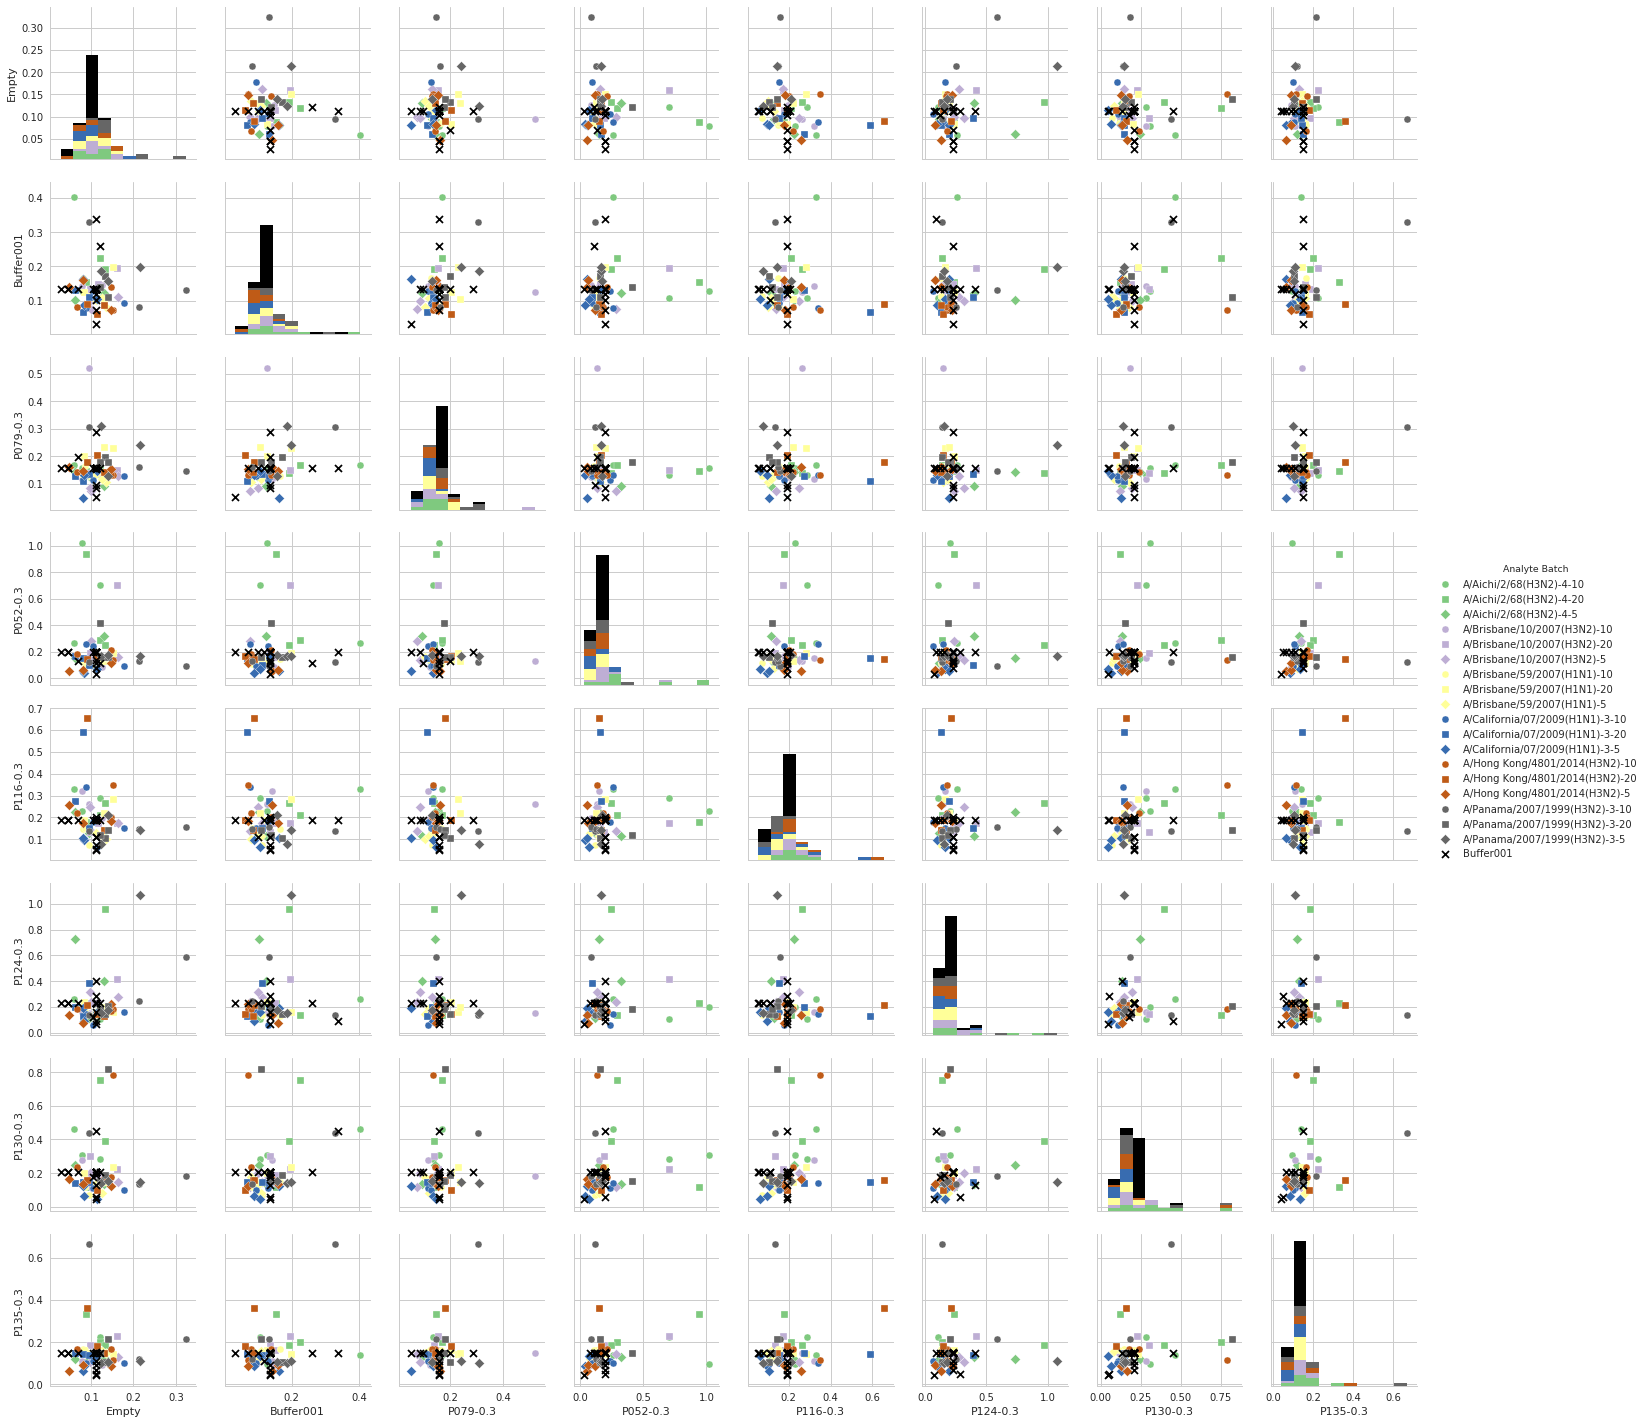

In [14]:
sns.pairplot(data=data_elisa.x.reset_index(),vars=["Empty","Buffer001","P079-0.3","P052-0.3","P116-0.3","P124-0.3","P130-0.3","P135-0.3"],hue="Analyte Batch",palette=color_list,markers= 6*["o","s","D"]+["x"])

In [15]:
d_analayte_x = data_elisa.spots_pd.pivot_table(values="Intensity",columns=["Ligand Batch","Analyte Batch Concentraion", "Replica"], index=["Analyte"])
d_new = d_analayte_x.transpose()

In [16]:

colors =  cmap(np.linspace(0,1,num=3))
color_list = []
for color in colors:
    #for i in range(3):
        color_list.append(color)
color_list += [np.array([0 ,0 , 0, 0]) ]

Correlation of Virsues 

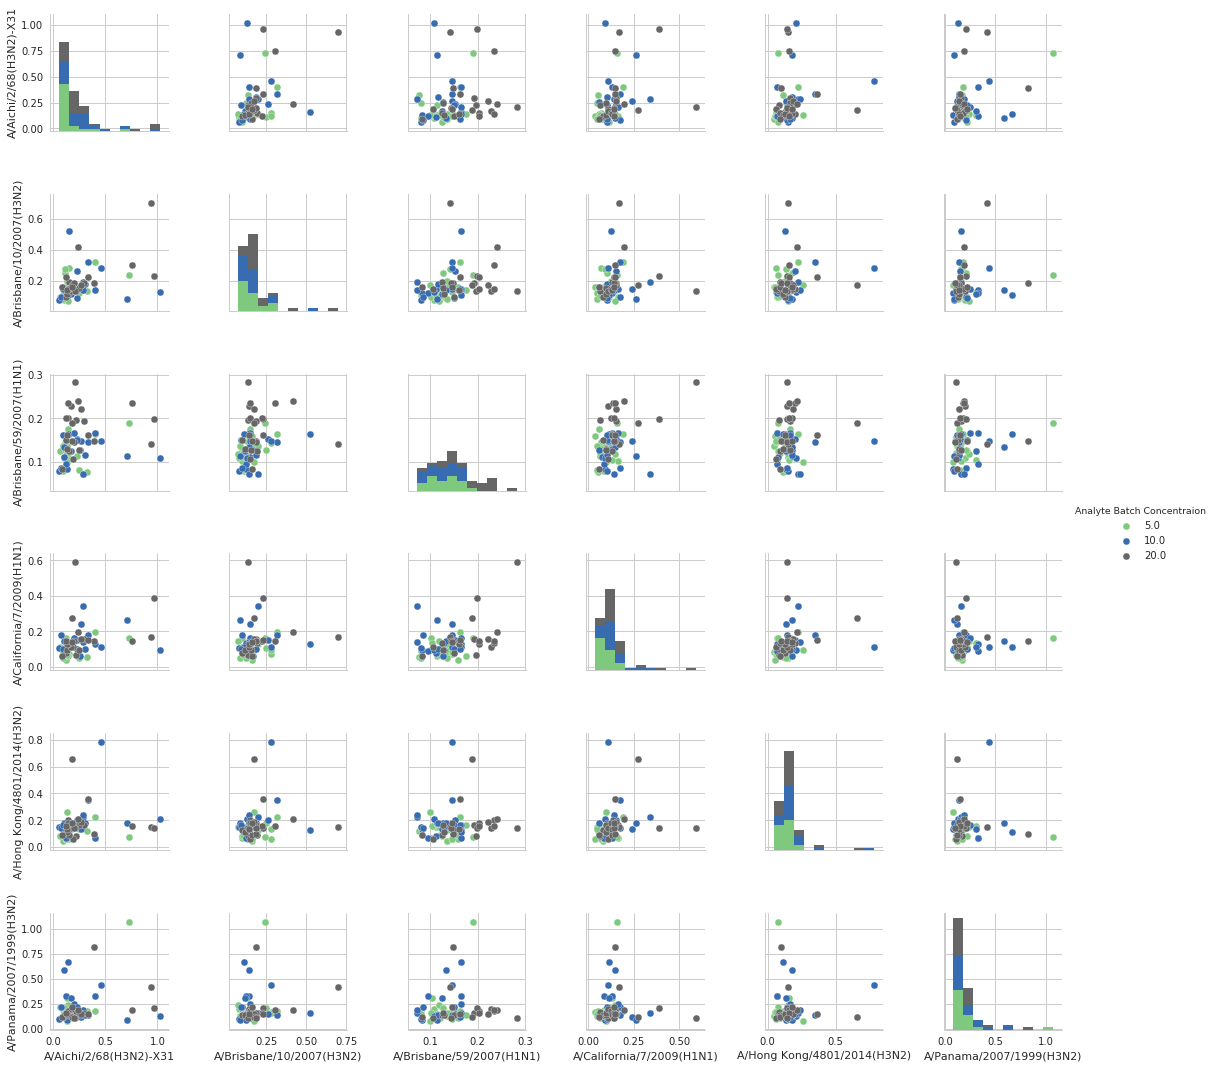

In [17]:
sns.pairplot(data=d_new.reset_index(),palette=color_list, hue="Analyte Batch Concentraion", vars=['A/Aichi/2/68(H3N2)-X31', 'A/Brisbane/10/2007(H3N2)', 'A/Brisbane/59/2007(H1N1)', 'A/California/7/2009(H1N1)', 'A/Hong Kong/4801/2014(H3N2)', 'A/Panama/2007/1999(H3N2)'])

## Heat/Cluster Map

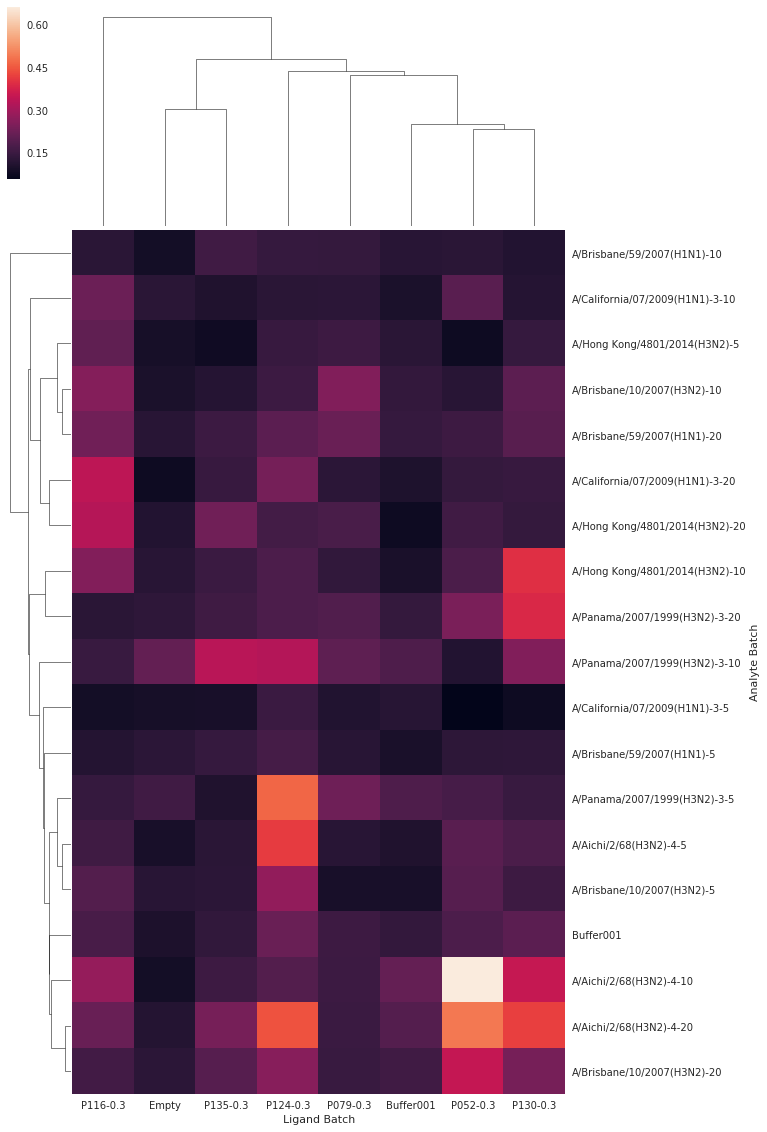

In [18]:
sns.clustermap(data_elisa.x.groupby("Analyte Batch").mean(),metric="correlation", method="single",figsize=(10,20))

## pca

In [19]:
model_pca = data_elisa.x_pca_fit()
elisa_pca = model_pca.transform(data_elisa.x)

In [20]:
#sns.heatmap(model_pca.scalings_, center=True)

In [21]:
# creating colors for pca
le = preprocessing.LabelEncoder()
le.fit(data_elisa.y_names)
cs = le.transform(data_elisa.y_names)
colors =cs.astype(float) / cs.max()

In [22]:
trace1 = go.Scatter3d(
    x=elisa_pca[:,0],
    y=elisa_pca[:,1],
    z=elisa_pca[:,2],
    text = data_elisa.y_names+"<br>"+data_elisa.x.index.get_level_values("Collection"),
    mode='markers',
    hoverinfo='text',
    #hoverlabel=dict(bgcolor=list(colors)),
    marker=dict(
        size=7,
        color=colors,                # set color to an array/list of desired values
        colorscale='Jet',   # choose a colorscale
        opacity=0.99)
)

this = [trace1]
layout = go.Layout(
    #scene=dict(
    #    xaxis = dict(showspikes=False),
    #    yaxis = dict(showspikes=False),
    #    zaxis = dict(showspikes=False),

        

     #   )
    )
fig = go.Figure(data=this, layout=layout)
iplot(fig, filename='3d-scatter-colorscale')

In [23]:
complete = pd.DataFrame(columns=["Test", "Train"])
com = data_elisa.collections.unique().values
complete.at[0, "Test"] = com
complete.at[0, "Train"] = com



In [24]:
#no cross-validation on different microwells possible possible without 
#no cross-validation on different microwells possible possible without 
ana = a2.Analysis(data_elisa, train_test=complete)
ana1 = a2.Analysis(data_elisa_norm1, train_test=complete)
ana2 = a2.Analysis(data_elisa_norm2, train_test=complete)
ana3 = a2.Analysis(data_elisa_norm3, train_test=complete)
ana4 = a2.Analysis(data_elisa_norm4, train_test=complete)

ana.calculate_all()
ana1.calculate_all()
ana2.calculate_all()
ana3.calculate_all()
ana4.calculate_all()

*****Nearest Neighbors*****
*****Fit Models*****
*****Predict*****
*****Decision Tree*****
*****Fit Models*****
*****Predict*****
*****LogisticRegression*****
*****Fit Models*****
*****Predict*****
*****Nearest Neighbors*****
*****Fit Models*****
*****Predict*****
*****Decision Tree*****
*****Fit Models*****
*****Predict*****
*****LogisticRegression*****
*****Fit Models*****
*****Predict*****
*****Nearest Neighbors*****
*****Fit Models*****
*****Predict*****
*****Decision Tree*****
*****Fit Models*****
*****Predict*****
*****LogisticRegression*****
*****Fit Models*****
*****Predict*****
*****Nearest Neighbors*****
*****Fit Models*****
*****Predict*****
*****Decision Tree*****
*****Fit Models*****
*****Predict*****
*****LogisticRegression*****
*****Fit Models*****
*****Predict*****
*****Nearest Neighbors*****
*****Fit Models*****
*****Predict*****
*****Decision Tree*****
*****Fit Models*****
*****Predict*****
*****LogisticRegression*****
*****Fit Models*****
*****Predict*****


In [25]:
def split_result(frame):
    result_dict = {}
    len_frame = int(len(frame)/3)
    result_dict["frame_NN"] = frame[:len_frame]
    result_dict["frame_DT"] = frame[len_frame:2*len_frame]
    result_dict["frame_LR"] = frame[2*len_frame:3*len_frame]
    return result_dict

In [26]:
result = split_result(ana.complete_information())
result1 = split_result(ana1.complete_information())
result2 = split_result(ana2.complete_information())
result3 = split_result(ana3.complete_information())
result4 = split_result(ana4.complete_information())


In [27]:
def render_result(data,name,ax,show=False,xlabel="",ylabel=""):
    data = data[""]
    sns.pointplot(data=data.reset_index().sort_values(by=["level_1","level_2"]),y="y",x="TrueFalse",ci=None, join=False,hue="y", markers="|",ax=ax)
    for c in ax.collections:
        for of in c.get_offsets():
            ax.annotate("{:.2f}".format(of[0]), of)
    sns.swarmplot(data=data.reset_index().sort_values(by=["level_1","level_2"]),y="y",x="TrueFalse",hue="level_2",ax=ax,palette=sns.color_palette("inferno"))#, jitter=0.5)#, aspect=0.8)
    if not show:
        ax.legend_.remove()
    ax.set_title(name, )
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)


In [38]:
result.iloc[result["frame_NN"].index.get_level_values(0) != 'Buffer001']


AttributeError: 'dict' object has no attribute 'iloc'

In [33]:
96/4

24.0

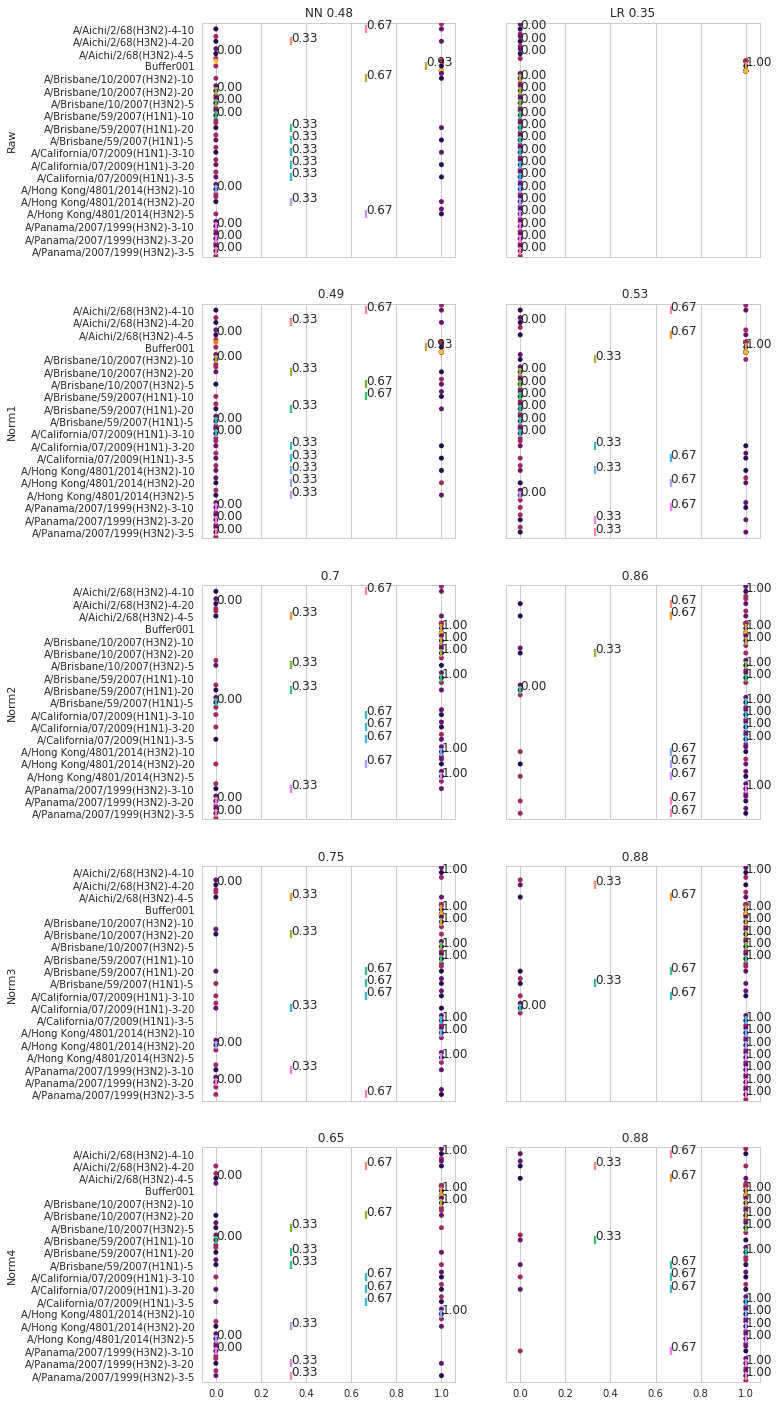

In [28]:
fig, ax = plt.subplots(ncols=2,nrows=5, figsize=(10,25),sharex=True, sharey=True)
#ax = sns.boxplot(data=frame_NN,y="y",x="TrueFalse",notch=True)

render_result(result["frame_NN"], "NN {:.02}".format(result["frame_NN"]["TrueFalse"].mean()), ax[0,0],ylabel="Raw")
#render_result(result["frame_DT"], "DT",ax[0,1])
render_result(result["frame_LR"], "LR {:.02}".format(result["frame_LR"]["TrueFalse"].mean()),ax[0,1])
render_result(result1["frame_NN"], " {:.02}".format(result1["frame_NN"]["TrueFalse"].mean()), ax[1,0],ylabel="Norm1")
#render_result(result1["frame_DT"], "",ax[1,1])
render_result(result1["frame_LR"], " {:.02}".format(result1["frame_LR"]["TrueFalse"].mean()),ax[1,1])
render_result(result2["frame_NN"], " {:.02}".format(result2["frame_NN"]["TrueFalse"].mean()), ax[2,0],ylabel="Norm2")
#render_result(result2["frame_DT"], "",ax[2,1])
render_result(result2["frame_LR"], " {:.02}".format(result2["frame_LR"]["TrueFalse"].mean()),ax[2,1])
render_result(result3["frame_NN"], " {:.02}".format(result3["frame_NN"]["TrueFalse"].mean()), ax[3,0],ylabel="Norm3")
#render_result(result3["frame_DT"], "",ax[3,1],show=True)
render_result(result3["frame_LR"], " {:.02}".format(result3["frame_LR"]["TrueFalse"].mean()),ax[3,1])
render_result(result4["frame_NN"], " {:.02}".format(result4["frame_NN"]["TrueFalse"].mean()), ax[4,0],ylabel="Norm4")
#render_result(result3["frame_DT"], "",ax[3,1],show=True)
render_result(result4["frame_LR"], " {:.02}".format(result4["frame_LR"]["TrueFalse"].mean()),ax[4,1])